In [1]:
import numpy as np
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt

from tqdm import tqdm

## Q1

In [2]:
np.random.seed(42)

m = 100  # sample size
n = 200  # dimension

A = np.random.randn(m, n)
b = np.random.randn(m)

L = 2 * np.linalg.norm(A, 2)**2
t = 1.0 / L 

#to compute optimal value f^*
def lasso(X, y, lambd):
    beta = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(y - X @ beta))
    constraints = [cp.norm1(beta) <= lambd]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    return prob.value 

## (A) Projected Gradient-Descent

In [3]:
def proj_l1(v, lambd):
    z = cp.Variable(v.shape[0])
    objective = cp.Minimize(cp.sum_squares(z - v))
    constraints = [cp.norm1(z) <= lambd]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    return z.value

def PGD_lasso(A, b, lambd, stepsize, iters):
    n = A.shape[1]
    x = np.zeros(n)
    f_vals = np.zeros(iters)

    for t in range(iters):
        grad = 2 * A.T @ (A @ x - b)
        x = proj_l1(x - stepsize * grad, lambd)
        f_vals[t] = np.linalg.norm(A @ x - b)**2

    return f_vals

## (B) Frank-Wolfe

In [4]:
def lmo_l1(grad, lambd):
    n = grad.shape[0]
    s = cp.Variable(n)
    objective = cp.Minimize(grad @ s)
    constraints = [cp.norm1(s) <= lambd]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    return s.value

def FW_lasso(A, b, lambd, iters):
    n = A.shape[1]
    x = np.zeros(n)
    f_vals = np.zeros(iters)

    for t in range(iters):
        grad = 2 * A.T @ (A @ x - b)
        s = lmo_l1(grad, lambd)
        stepsize = 2.0/(t+2.0)
        x = x + stepsize * (s - x)
        f_vals[t] = np.linalg.norm(A @ x - b)**2
        
    return f_vals

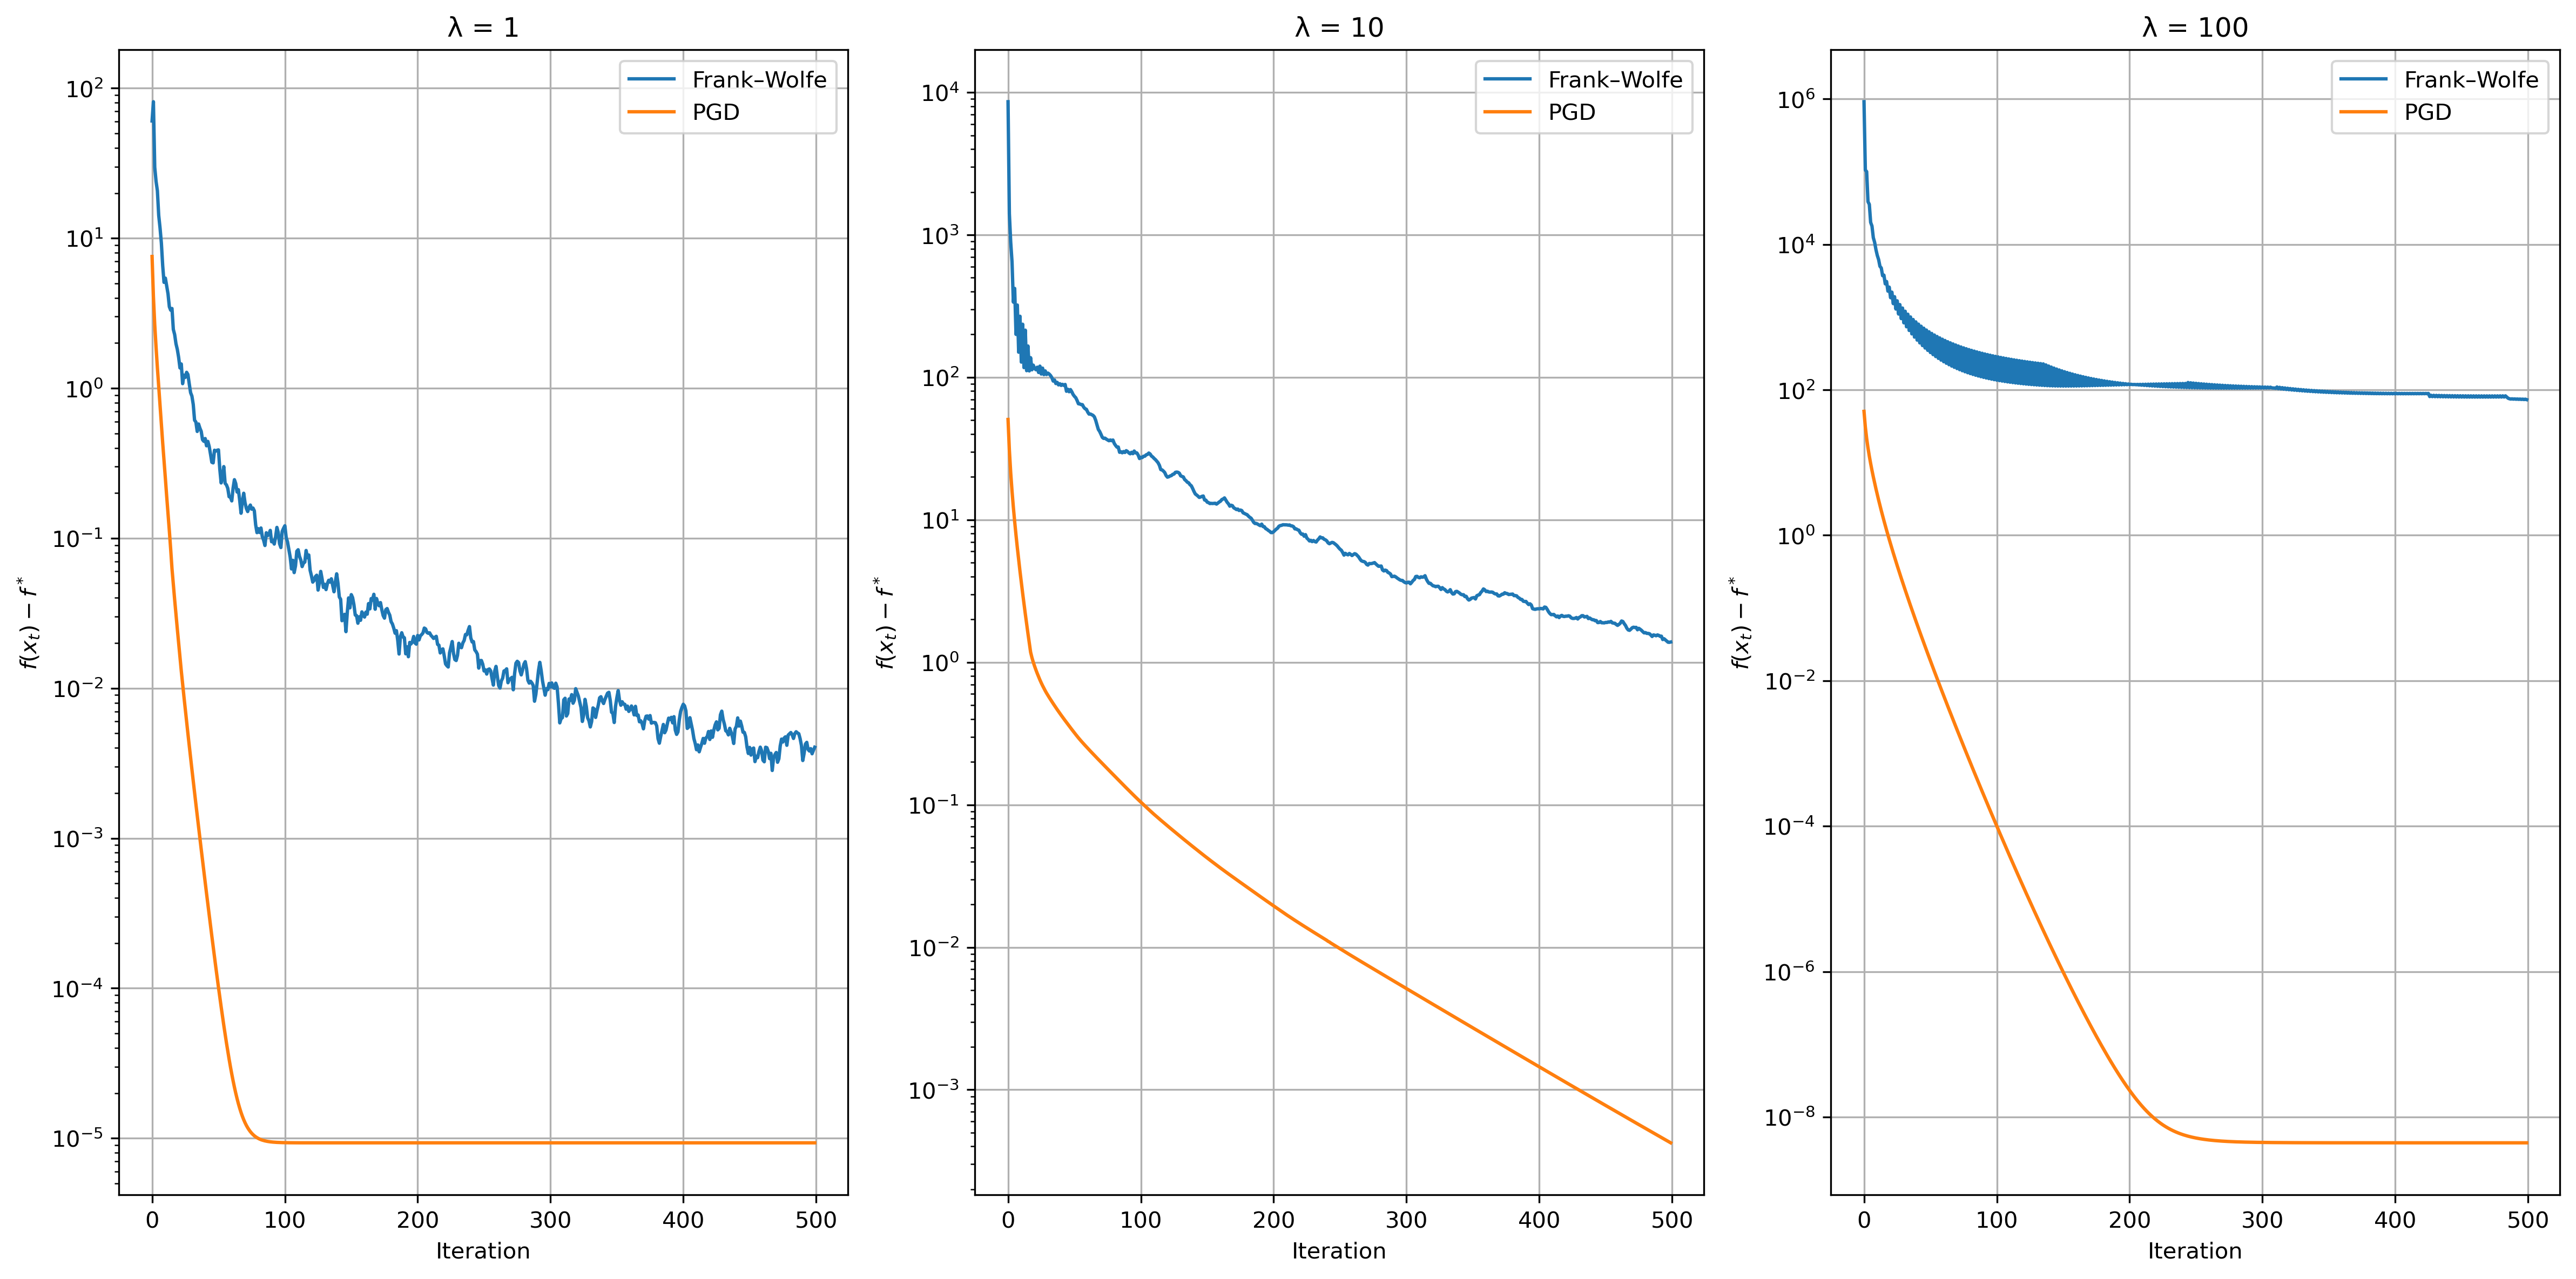

In [5]:
lambdas = [1, 10, 100]
iters = 500

f_star = {lam: lasso(A, b, lam) for lam in lambdas}
hist_FW = {lam: FW_lasso(A, b, lam, iters) for lam in lambdas}
hist_PGD = {lam: PGD_lasso(A, b, lam, t, iters) for lam in lambdas}

fig, axes = plt.subplots(1, 3, figsize=(16,8),dpi=300)
for ax, lam in zip(axes, lambdas):
    ax.plot(hist_FW[lam] - f_star[lam], label='Frank–Wolfe')
    ax.plot(hist_PGD[lam] - f_star[lam], label='PGD')
    ax.set_yscale('log')
    ax.set_title(f'λ = {lam}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$f(x_t) - f^*$')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Q3

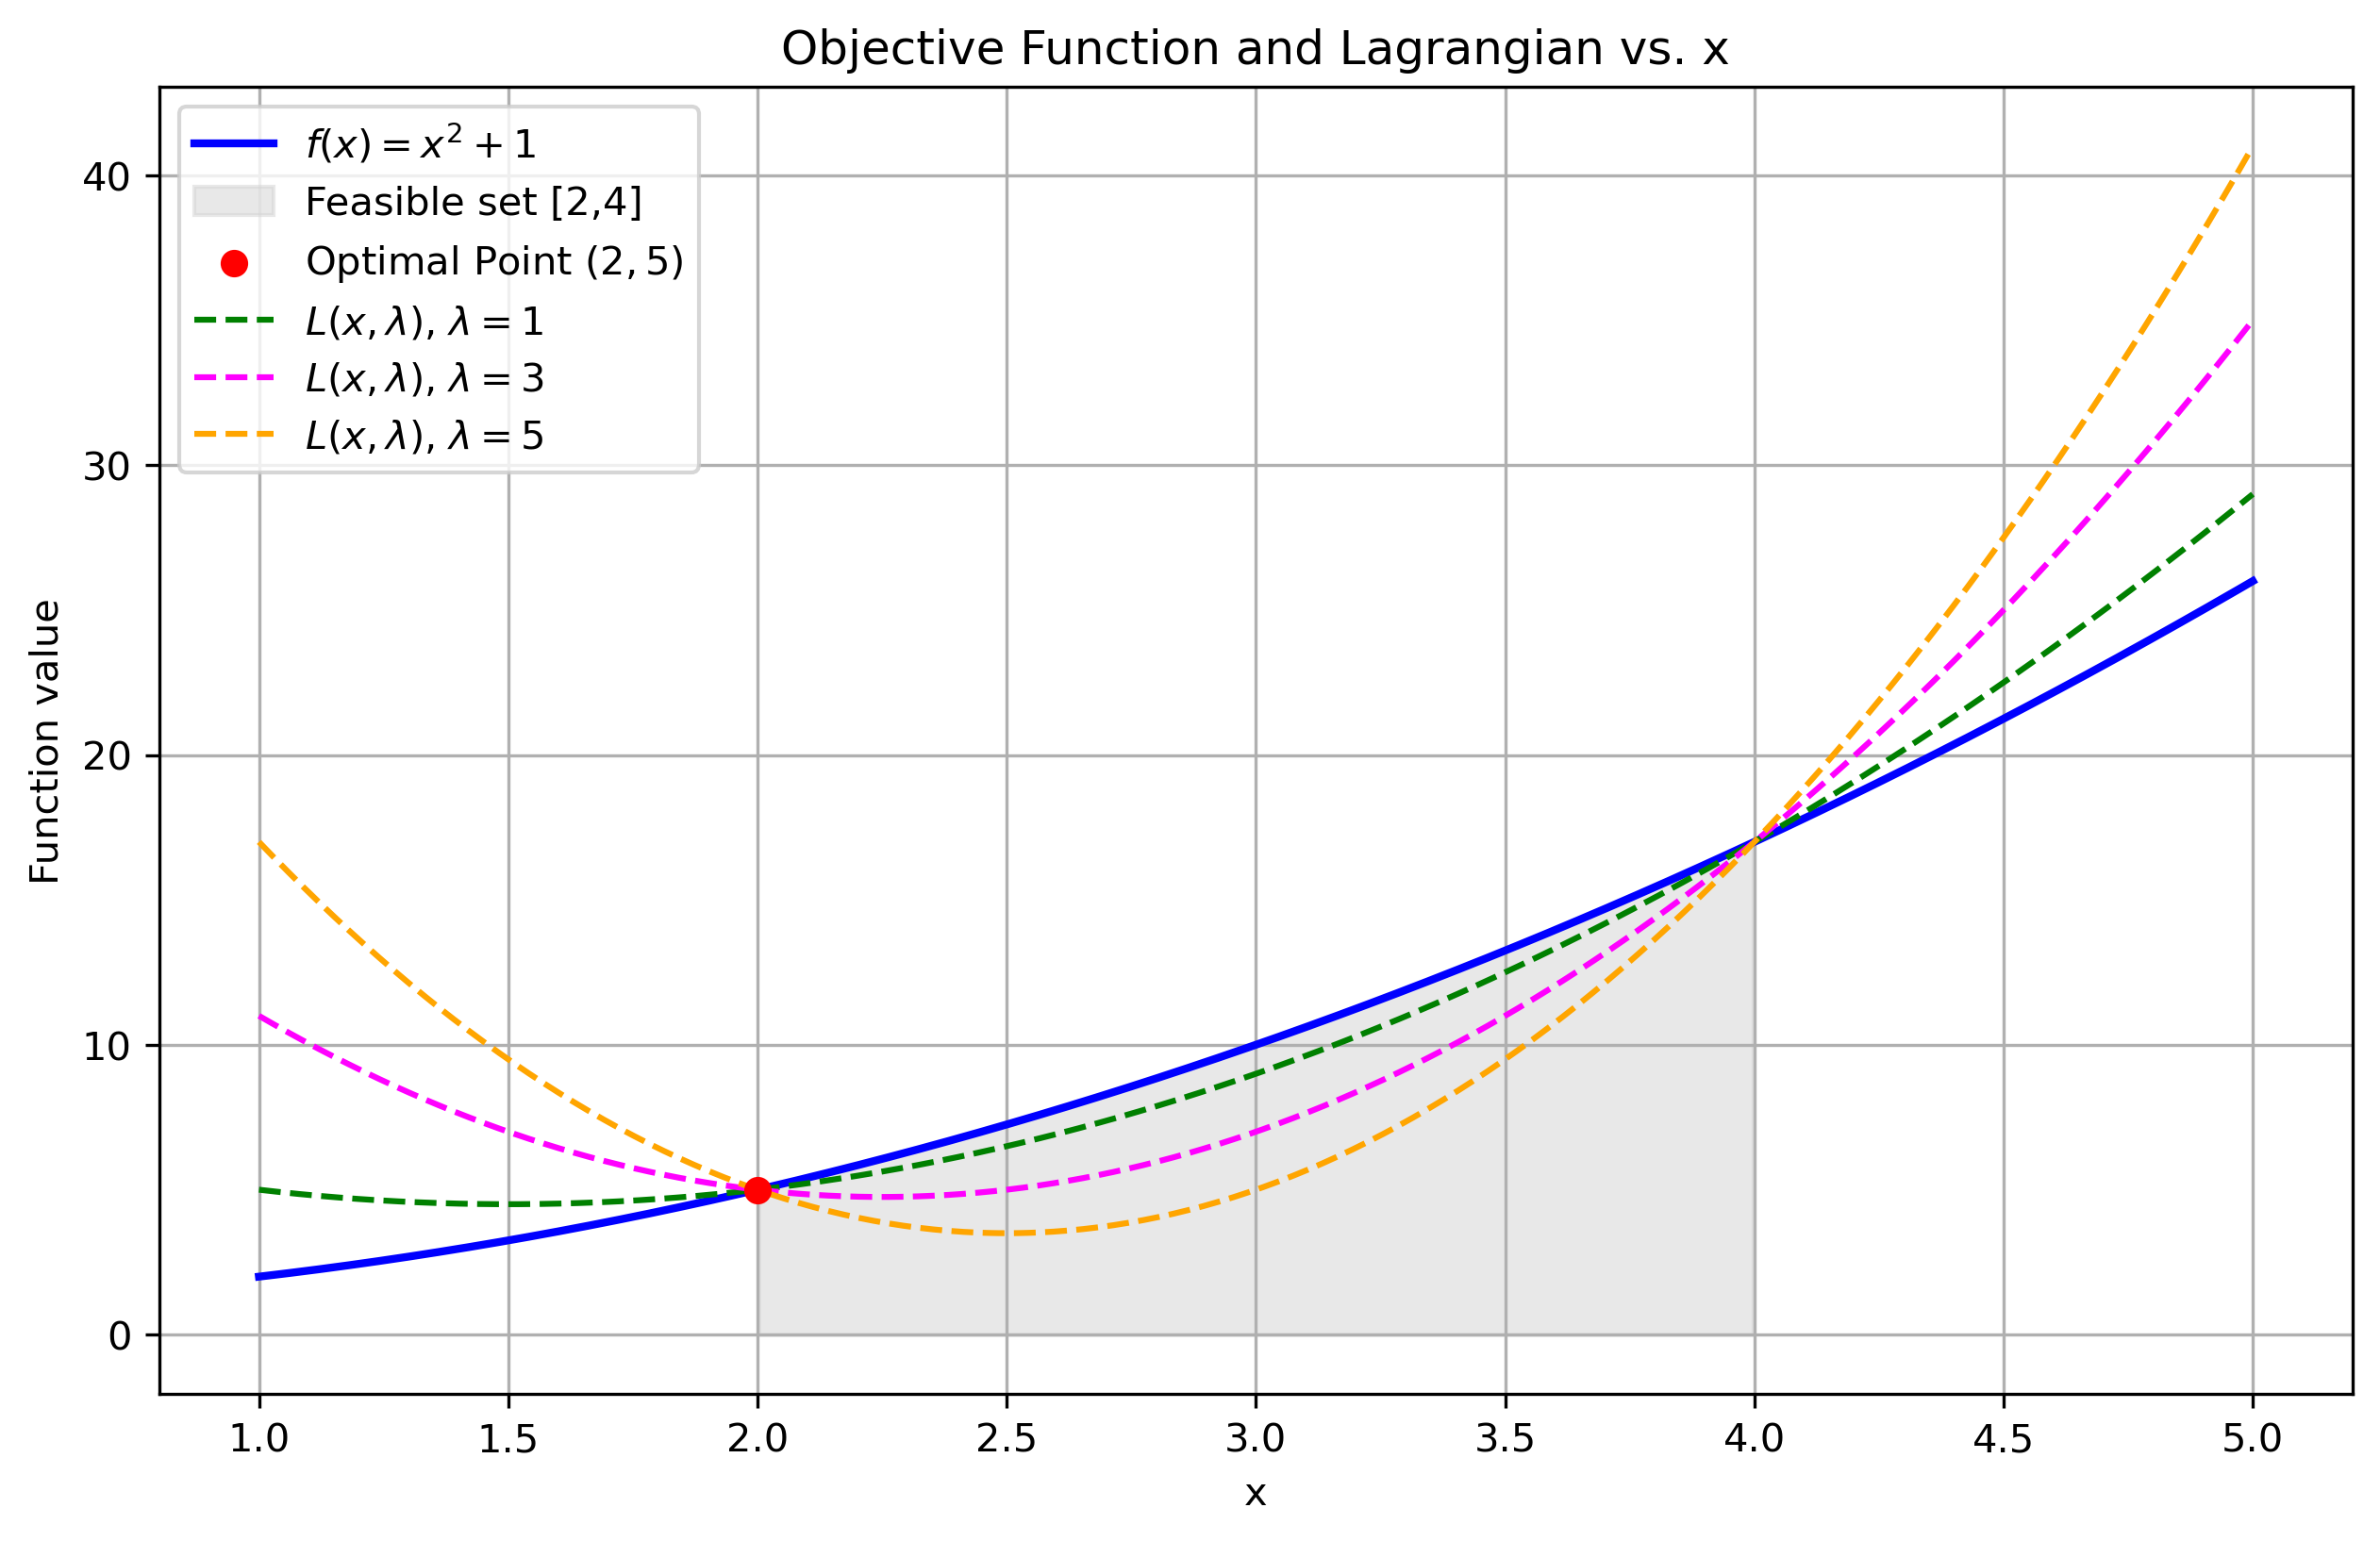

In [6]:
def objective(x):
    return x**2 + 1

def constraint(x):
    return (x - 2) * (x - 4)

def lagrangian(x, lam):
    return objective(x) + lam * constraint(x)

x = np.linspace(1, 5, 400)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x, objective(x), label=r'$f(x)=x^2+1$', color='blue', linewidth=2)


plt.fill_between(x, objective(x), where=(x >= 2) & (x <= 4), color='lightgray', alpha=0.5, label='Feasible set [2,4]')


opt_x = 2
opt_val = objective(opt_x)
plt.scatter([opt_x], [opt_val], color='red', zorder=5, label=r'Optimal Point $(2,5)$')


lambdas = [1, 3, 5] 
colors = ['green', 'magenta', 'orange']
for lam, color in zip(lambdas, colors):
    plt.plot(x, lagrangian(x, lam), label=r'$L(x,\lambda)$, $\lambda=$' + str(lam), color=color, linestyle='--')


plt.title('Objective Function and Lagrangian vs. x')
plt.xlabel('x')
plt.ylabel('Function value')
plt.legend()
plt.grid(True)

plt.show()

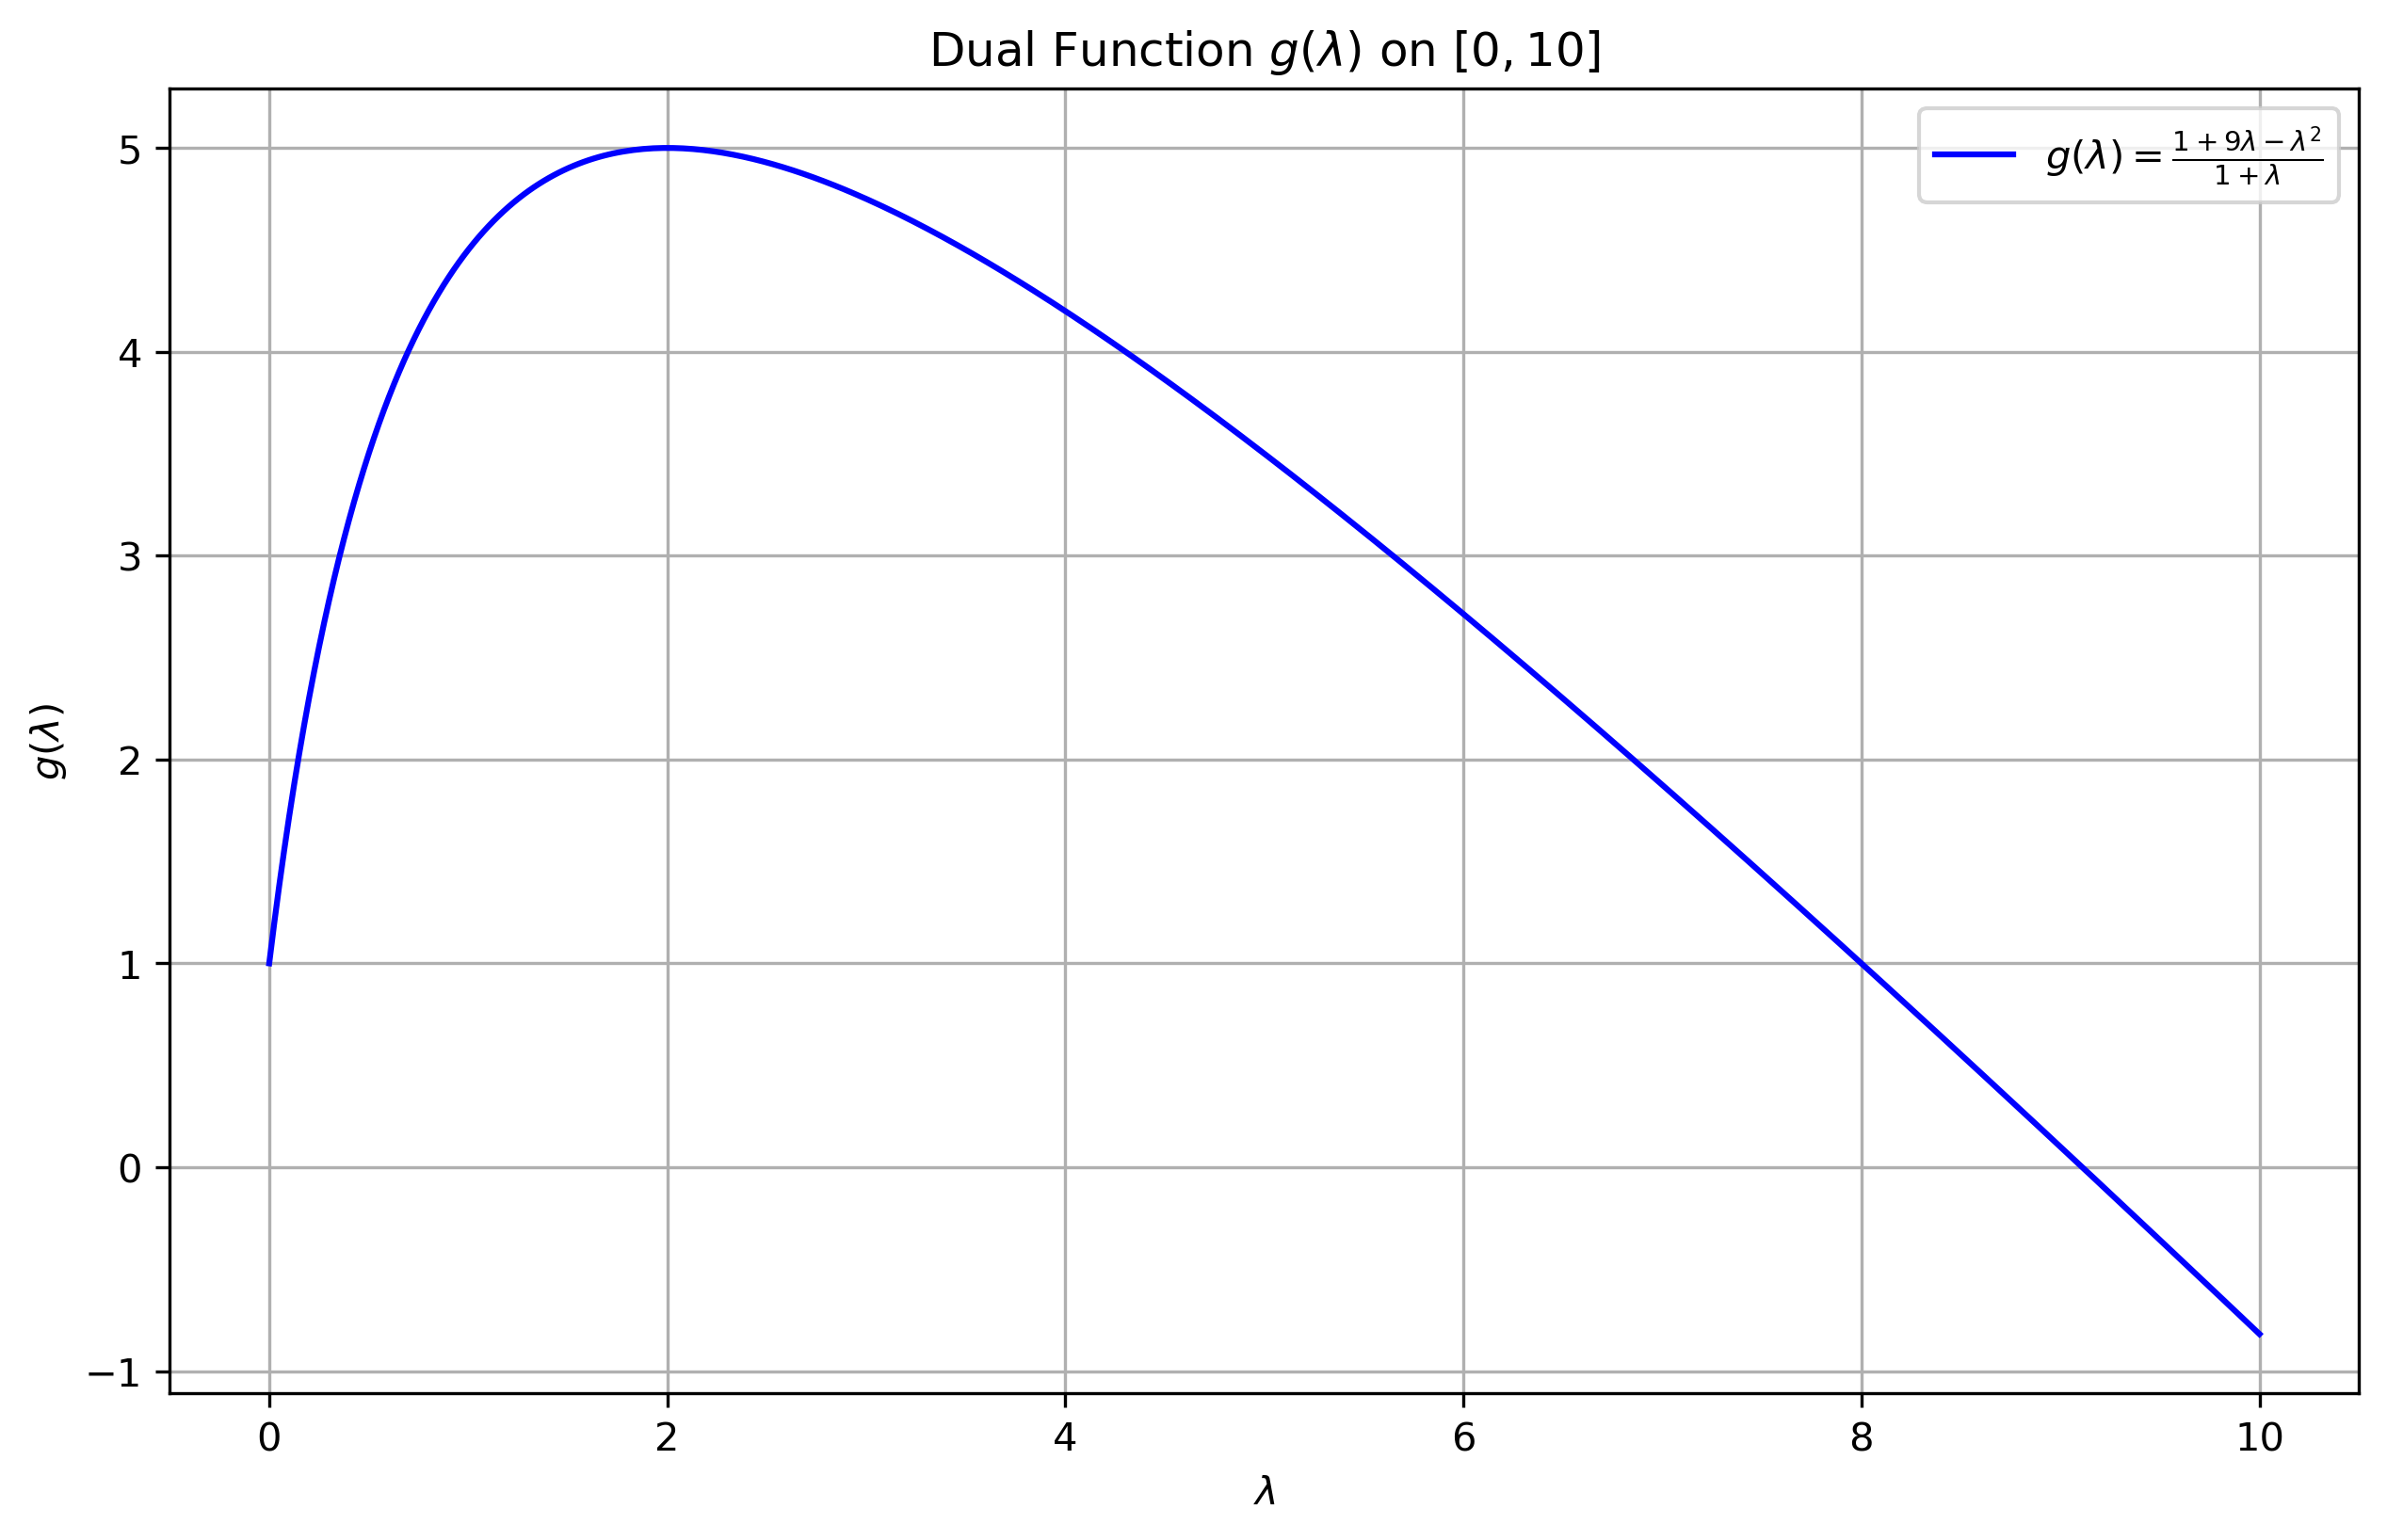

In [7]:
def g(lam):
    return (1 + 9*lam - lam**2) / (1 + lam)

lam_values = np.linspace(0, 10, 400)
g_values = g(lam_values)

plt.figure(figsize=(10, 6),dpi=300)
plt.plot(lam_values, g_values, label=r'$g(\lambda)=\frac{1+9\lambda-\lambda^2}{1+\lambda}$', color='blue')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$g(\lambda)$')
plt.title('Dual Function $g(\lambda)$ on $[0,10]$')
plt.legend()
plt.grid(True)
plt.show()

## Q8

## (i) Gradient of Least Square

The gradient is $2X^\top(X\beta - y)$

## (ii) Proximal Gradient Descent

Hard code the group indices and group omegas.

In [8]:
group_indices = [
    [0],         
    [1, 2, 3],  
    [4, 5, 6],        
    [7, 8],    
    [9],             
    [10, 11],         
    [12],           
    [13],      
    [14, 15, 16]      
]

group_omegas = [
    0.0,              # no penalty on intercept
    np.sqrt(3),
    np.sqrt(3),
    np.sqrt(2),
    1.0,
    np.sqrt(2),
    1.0,
    1.0,
    np.sqrt(3)
]

def proximal_operator(x, t, lamda):
    x = np.asarray(x)
    prox = np.zeros_like(x)
    for idxs, omega in zip(group_indices, group_omegas):
        x_j = x[idxs]
        norm_j = np.linalg.norm(x_j, 2)
        c = (1 - (t * lamda * omega) / norm_j) if norm_j > 0 else 0
        if c < 0:
            c = 0
        prox[idxs] = c * x_j
    return prox

In [9]:
def proximal_group_lasso(X, y, lambd, t, iters):
    p = X.shape[1]
    beta   = np.ones(p)
    f_vals = np.zeros(iters)

    for k in tqdm(range(iters), desc="proximal"):
        grad = 2 * X.T @ (X @ beta - y)
        beta = proximal_operator(beta - t * grad, t, lambd)

        obj = np.linalg.norm(X @ beta - y)**2
        for idxs, omega in zip(group_indices, group_omegas):
            obj += lambd * omega * np.linalg.norm(beta[idxs])
        f_vals[k] = obj

    return beta, f_vals

In [10]:
def accelerated_proximal_group_lasso(X, y, lambd, t, iters):
    p = X.shape[1]
    beta_prev      = np.ones(p)
    beta_prev_prev = np.ones(p)
    f_vals         = np.zeros(iters)

    for k in tqdm(range(1, iters+1),desc="acc-proximal"):
        if k == 1:
            v = beta_prev
        else:
            v = beta_prev + (k-2)/(k+1) * (beta_prev - beta_prev_prev)

        grad = 2 * X.T @ (X @ v - y)
        beta = proximal_operator(v - t * grad, t, lambd)

        obj = np.linalg.norm(X @ beta - y)**2
        for idxs, omega in zip(group_indices, group_omegas):
            obj += lambd * omega * np.linalg.norm(beta[idxs])
        f_vals[k-1] = obj

        beta_prev_prev = beta_prev
        beta_prev      = beta

    return beta_prev, f_vals

In [11]:
import pandas as pd

X = pd.read_csv("X.csv").values 
ones = np.ones((X.shape[0], 1))
X = np.hstack([ones, X])
y = pd.read_csv("y.csv").values
y = y.reshape(-1)    

print("X:", X.shape, "y:", y.shape)

X: (189, 17) y: (189,)


In [12]:
t = 0.002
lambd = 4
iters = 1000
beta_prox, obj_prox = proximal_group_lasso(X, y, lambd, t, iters)
beta_acc, obj_acc = accelerated_proximal_group_lasso(X, y, lambd, t, iters)

acc-proximal: 100%|██████████████████████| 1000/1000 [00:00<00:00, 17380.10it/s]


In [13]:
print(obj_prox[-1], obj_acc[-1])

84.6952082766263 84.69520827662632


We use CVXPY to find the optimal value.

In [14]:
def group_lasso(X, y, lambd):
    p = X.shape[1]
    beta = cp.Variable(p)
    loss = cp.sum_squares(X @ beta - y)

    penalty = 0
    for idxs, omega in zip(group_indices, group_omegas):
        penalty += omega * cp.norm(beta[idxs], 2)

    objective = loss + lambd * penalty
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve(solver=cp.MOSEK)

    return beta.value, problem.value

In [15]:
beta_opt, obj_opt = group_lasso(X, y, lambd)
print(obj_opt)

84.69520831035122


## (ii) Convergence of Proximal Gradient Descent

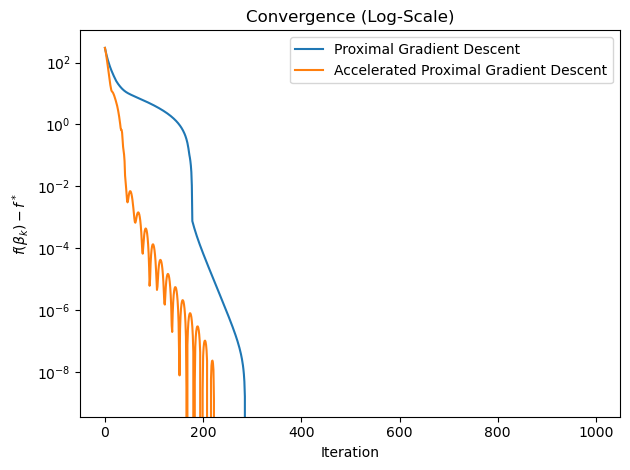

In [16]:
iters = np.arange(len(obj_prox))

plt.figure()
plt.plot(iters, obj_prox - obj_opt, label='Proximal Gradient Descent')
plt.plot(iters, obj_acc - obj_opt, label='Accelerated Proximal Gradient Descent')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(\beta_k) - f^*$')
plt.title('Convergence (Log-Scale)')
plt.legend()
plt.tight_layout()
plt.show()

## (iii) Coefficients

In [17]:
print(np.round(beta_prox,3))

[ 3.018e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00
  0.000e+00  3.030e-01 -5.400e-02 -2.890e-01 -2.250e-01  3.400e-02
 -2.750e-01 -4.580e-01  2.300e-02  3.000e-03 -9.000e-03]


In [18]:
print(np.round(beta_acc,3))

[ 3.018e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00
  0.000e+00  3.030e-01 -5.400e-02 -2.890e-01 -2.250e-01  3.400e-02
 -2.750e-01 -4.580e-01  2.300e-02  3.000e-03 -9.000e-03]


The coefficients are the same, and the first two groups (excluding the intercept) are not selected, which is mother's age and mother's weight.

## (iv) Lasso

We let each coefficients be a singleton group.

In [19]:
p = 17
group_indices = [[j] for j in range(p)]
group_omegas  = [1.0] * p

In [20]:
L = 2 * np.linalg.norm(X, 2)**2
t = 1.0 / L 

In [21]:
beta_lasso, obj_lasso = accelerated_proximal_group_lasso(X, y, 0.35, t, 10000)

acc-proximal: 100%|████████████████████| 10000/10000 [00:00<00:00, 11874.59it/s]


In [22]:
print(np.round(beta_lasso,4))

[ 3.0412 -0.      1.3962  0.7315  1.6749  0.      1.1948  0.3013 -0.1331
 -0.2817 -0.2979  0.1847 -0.5335 -0.4744  0.0856  0.0141 -0.1491]


Comparing the solutions, when we run lasso, it happens that it selected coefficients from a group that were not selected by group lasso, for example, the first coefficient from the group of age.